/var/folders/6y/gvfh979s4nb35bcvpht0ntlm0000gn/T/ipykernel_8488/1031983475.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.set_index('timestamp').groupby('enbid_pci').resample('1H').agg({'RBused': 'sum', 'Holiday': 'first'}).reset_index()


클러스터링 완료. 각 클러스터의 크기:
cluster
3    221
1    192
0    141
4     53
2     39
Name: count, dtype: int64


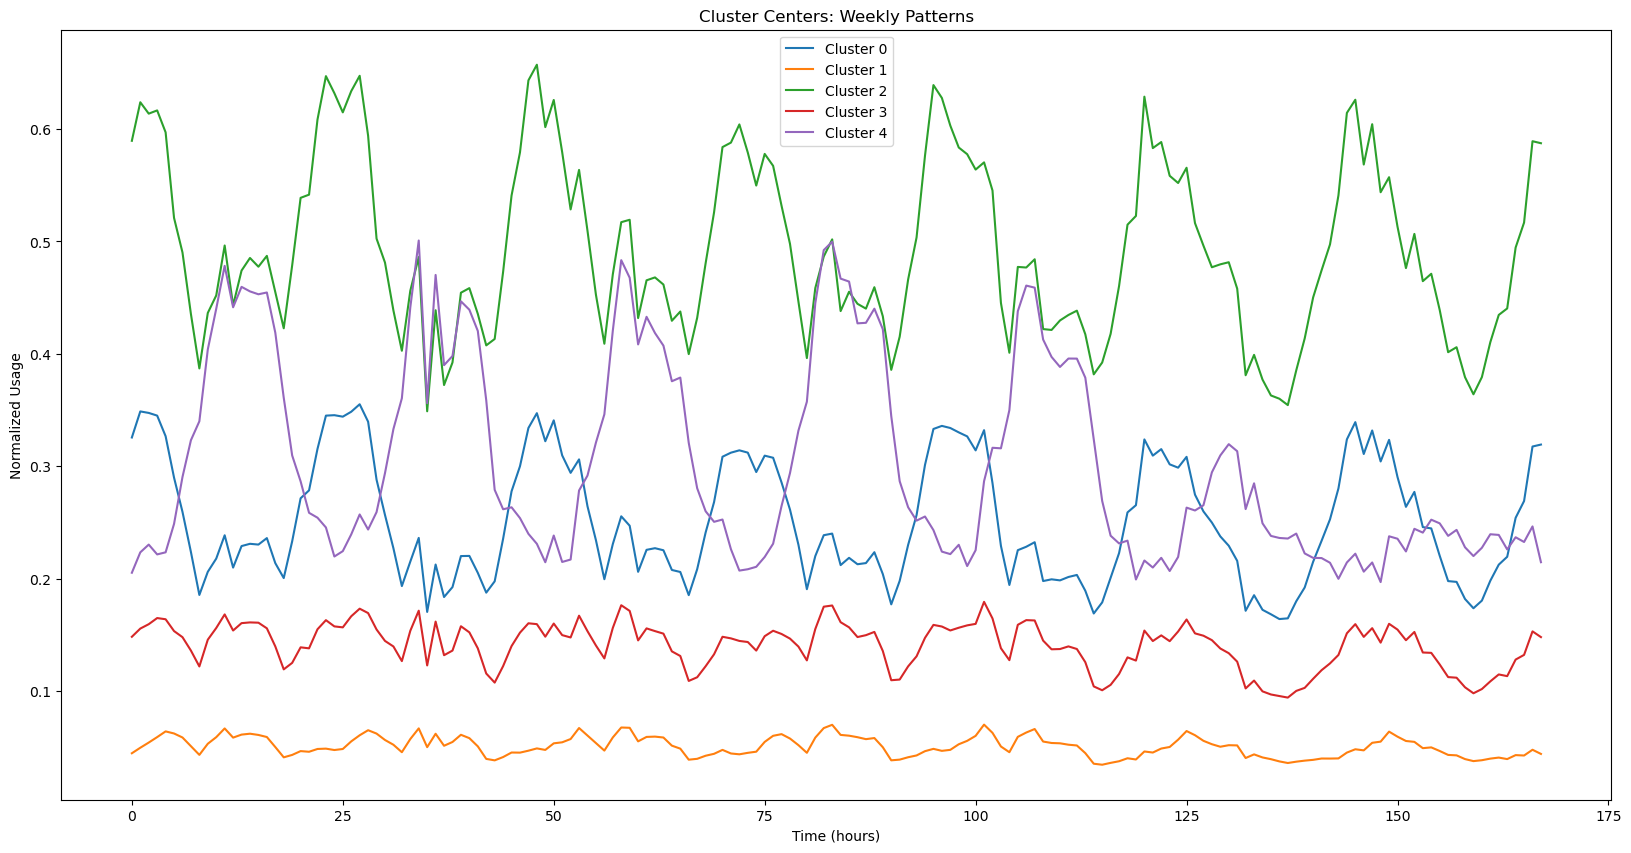


Cluster 0 주요 특성:
night_hours_usage    0.175510
morning_peak         0.110574
peak_hours_usage     0.103601
evening_peak         0.097432
weekday_hour1        0.029443
Name: 0, dtype: float64

Cluster 1 주요 특성:
night_hours_usage    0.028065
morning_peak         0.025774
peak_hours_usage     0.025676
evening_peak         0.020438
weekday_hour11       0.005715
Name: 1, dtype: float64

Cluster 2 주요 특성:
night_hours_usage    0.322274
morning_peak         0.221633
peak_hours_usage     0.217229
evening_peak         0.207078
weekday_hour1        0.053582
Name: 2, dtype: float64

Cluster 3 주요 특성:
night_hours_usage    0.083578
morning_peak         0.070001
peak_hours_usage     0.067473
evening_peak         0.057120
weekday_hour11       0.014260
Name: 3, dtype: float64

Cluster 4 주요 특성:
peak_hours_usage     0.183954
morning_peak         0.173254
evening_peak         0.154924
night_hours_usage    0.121269
weekday_hour11       0.040283
Name: 4, dtype: float64


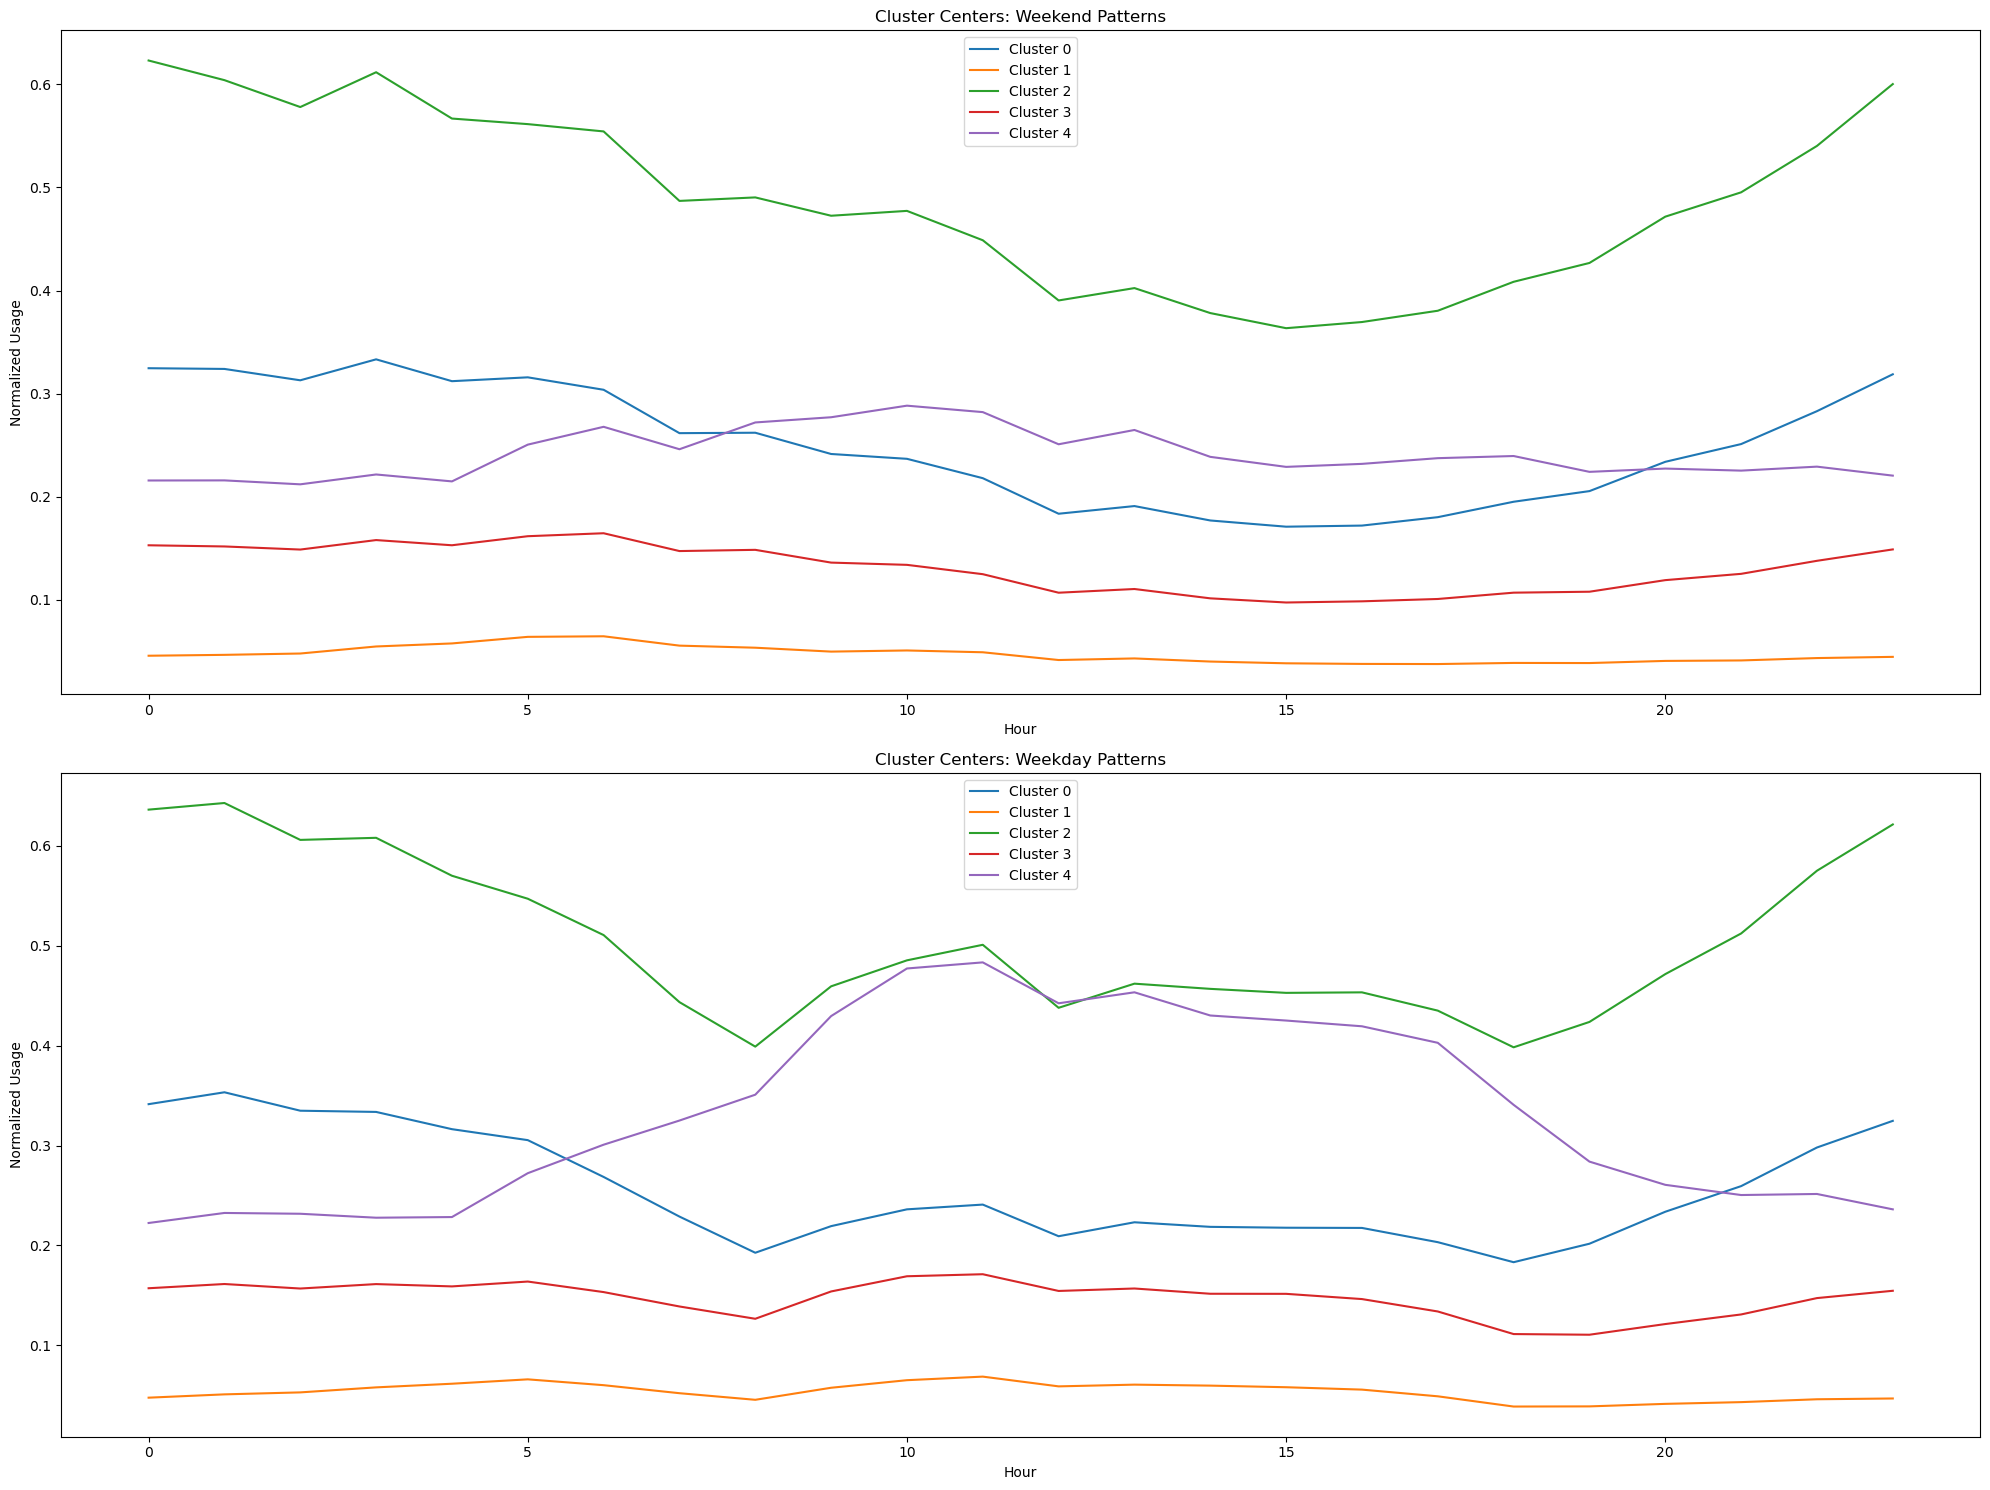

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
df = pd.read_csv('ELG_Busan_PoC_per_CA_site_0226_0519.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 1시간 간격으로 데이터 리샘플링
df_hourly = df.set_index('timestamp').groupby('enbid_pci').resample('1H').agg({'RBused': 'sum', 'Holiday': 'first'}).reset_index()

# 요일 및 시간 정보 추가
df_hourly['day_of_week'] = df_hourly['timestamp'].dt.dayofweek
df_hourly['hour'] = df_hourly['timestamp'].dt.hour
df_hourly['is_weekend'] = df_hourly['day_of_week'].isin([5, 6])

# 일주일 동안의 시간별 트래픽 패턴 생성
weekly_pattern = df_hourly.groupby(['enbid_pci', 'day_of_week', 'hour'])['RBused'].mean().unstack(level=[1,2])
weekly_pattern.columns = [f'day{day}_hour{hour}' for day, hour in weekly_pattern.columns]

# 주말/평일 시간대별 평균 생성
weekend_pattern = df_hourly[df_hourly['is_weekend']].groupby(['enbid_pci', 'hour'])['RBused'].mean().unstack()
weekend_pattern.columns = [f'weekend_hour{hour}' for hour in weekend_pattern.columns]

weekday_pattern = df_hourly[~df_hourly['is_weekend']].groupby(['enbid_pci', 'hour'])['RBused'].mean().unstack()
weekday_pattern.columns = [f'weekday_hour{hour}' for hour in weekday_pattern.columns]

# 시간 특성 생성 함수
def create_time_features(df):
    peak_hours_usage = df[df['hour'].between(9, 18)].groupby('enbid_pci')['RBused'].mean()
    night_hours_usage = df[df['hour'].between(0, 5)].groupby('enbid_pci')['RBused'].mean()
    morning_peak = df[(df['hour'] >= 7) & (df['hour'] < 10)].groupby('enbid_pci')['RBused'].mean()
    evening_peak = df[(df['hour'] >= 17) & (df['hour'] < 20)].groupby('enbid_pci')['RBused'].mean()
    
    return pd.DataFrame({
        'peak_hours_usage': peak_hours_usage,
        'night_hours_usage': night_hours_usage,
        'morning_peak': morning_peak,
        'evening_peak': evening_peak
    })

# 시간 특성 계산
time_features = create_time_features(df_hourly)

# 모든 특성을 하나의 DataFrame으로 결합
combined_features = pd.concat([weekly_pattern, weekend_pattern, weekday_pattern, time_features], axis=1)

# 전체 특성에 대해 정규화 적용
scaler = MinMaxScaler()
combined_features_scaled = pd.DataFrame(scaler.fit_transform(combined_features),
                                        columns=combined_features.columns,
                                        index=combined_features.index)

# 가중치 적용
weekly_pattern_columns = weekly_pattern.columns
weekend_pattern_columns = weekend_pattern.columns
weekday_pattern_columns = weekday_pattern.columns
time_features_columns = time_features.columns

weighted_features = combined_features_scaled.copy()
weighted_features[weekly_pattern_columns] *= 4 / len(weekly_pattern_columns)
weighted_features[weekend_pattern_columns] *= 2 / len(weekend_pattern_columns)
weighted_features[weekday_pattern_columns] *= 2 / len(weekday_pattern_columns)
weighted_features[time_features_columns] *= 2 / len(time_features_columns)

# 클러스터링 수행
n_clusters = 5  # 클러스터 수는 필요에 따라 조정 가능
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(weighted_features)

# 결과를 원본 데이터에 추가
combined_features_scaled['cluster'] = cluster_labels
print("클러스터링 완료. 각 클러스터의 크기:")
print(combined_features_scaled['cluster'].value_counts())

# 클러스터 중심 시각화 (주간 패턴)
plt.figure(figsize=(20, 10))
for i in range(n_clusters):
    cluster_center = kmeans.cluster_centers_[i][:168] * len(weekly_pattern_columns) / 4  # 가중치 제거
    plt.plot(cluster_center, label=f'Cluster {i}')
plt.title("Cluster Centers: Weekly Patterns")
plt.xlabel("Time (hours)")
plt.ylabel("Normalized Usage")
plt.legend()
plt.show()

# 클러스터별 특성 분석
cluster_means = weighted_features.groupby(cluster_labels).mean()
for cluster in range(n_clusters):
    print(f"\nCluster {cluster} 주요 특성:")
    print(cluster_means.iloc[cluster].nlargest(5))  # 상위 5개 특성 출력

# 주말/평일 패턴 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15))

for i in range(n_clusters):
    weekend_center = kmeans.cluster_centers_[i][168:192] * len(weekend_pattern_columns) / 2  # 가중치 제거
    weekday_center = kmeans.cluster_centers_[i][192:216] * len(weekday_pattern_columns) / 2  # 가중치 제거
    ax1.plot(weekend_center, label=f'Cluster {i}')
    ax2.plot(weekday_center, label=f'Cluster {i}')

ax1.set_title("Cluster Centers: Weekend Patterns")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Normalized Usage")
ax1.legend()

ax2.set_title("Cluster Centers: Weekday Patterns")
ax2.set_xlabel("Hour")
ax2.set_ylabel("Normalized Usage")
ax2.legend()

plt.tight_layout()
plt.show()

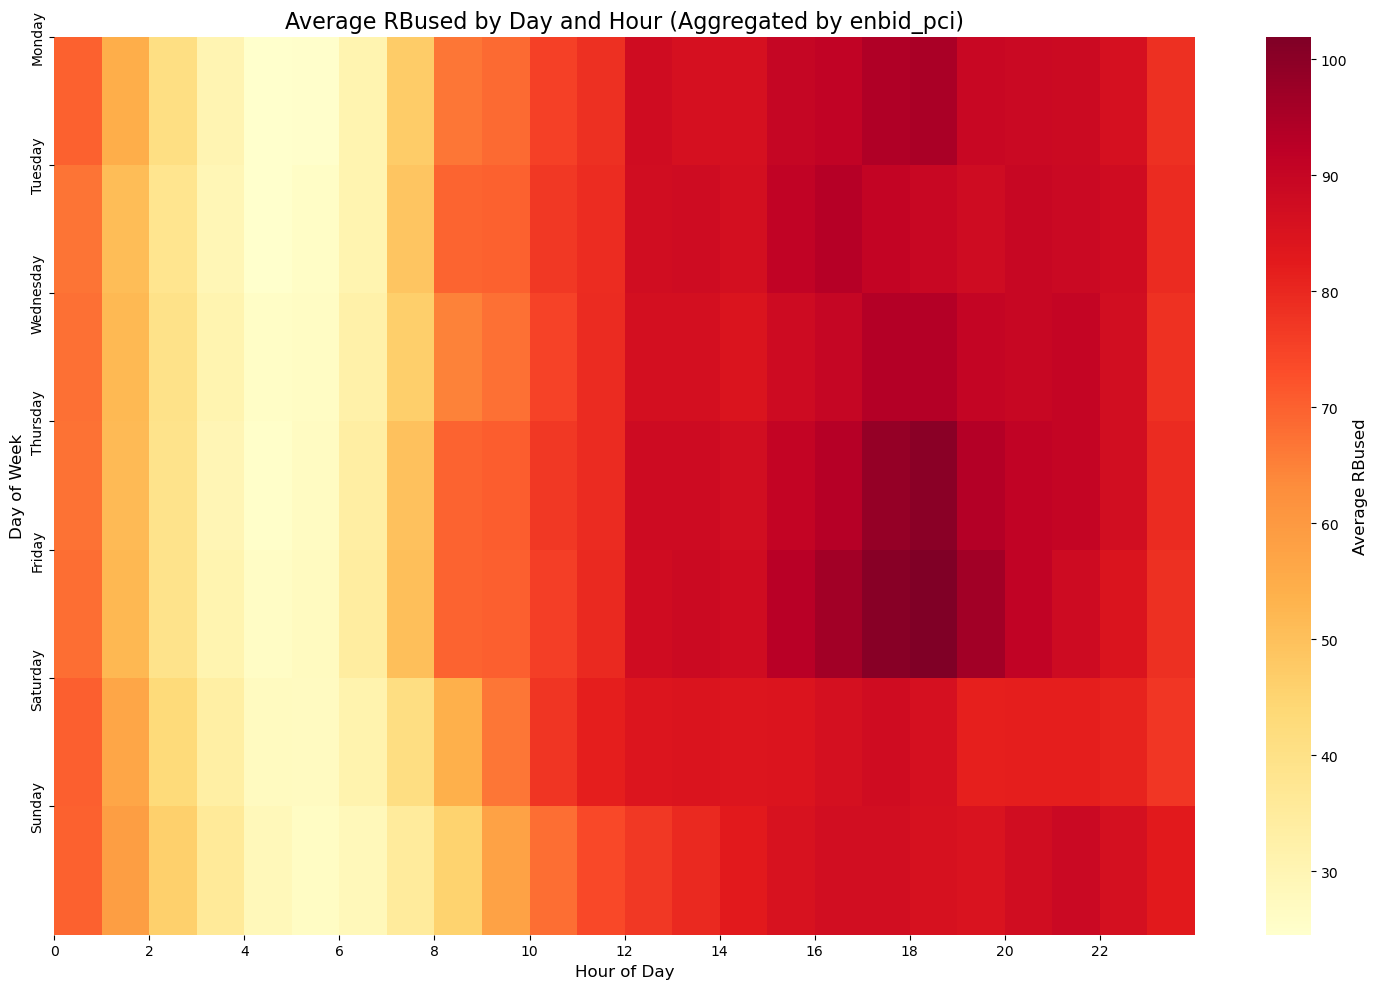

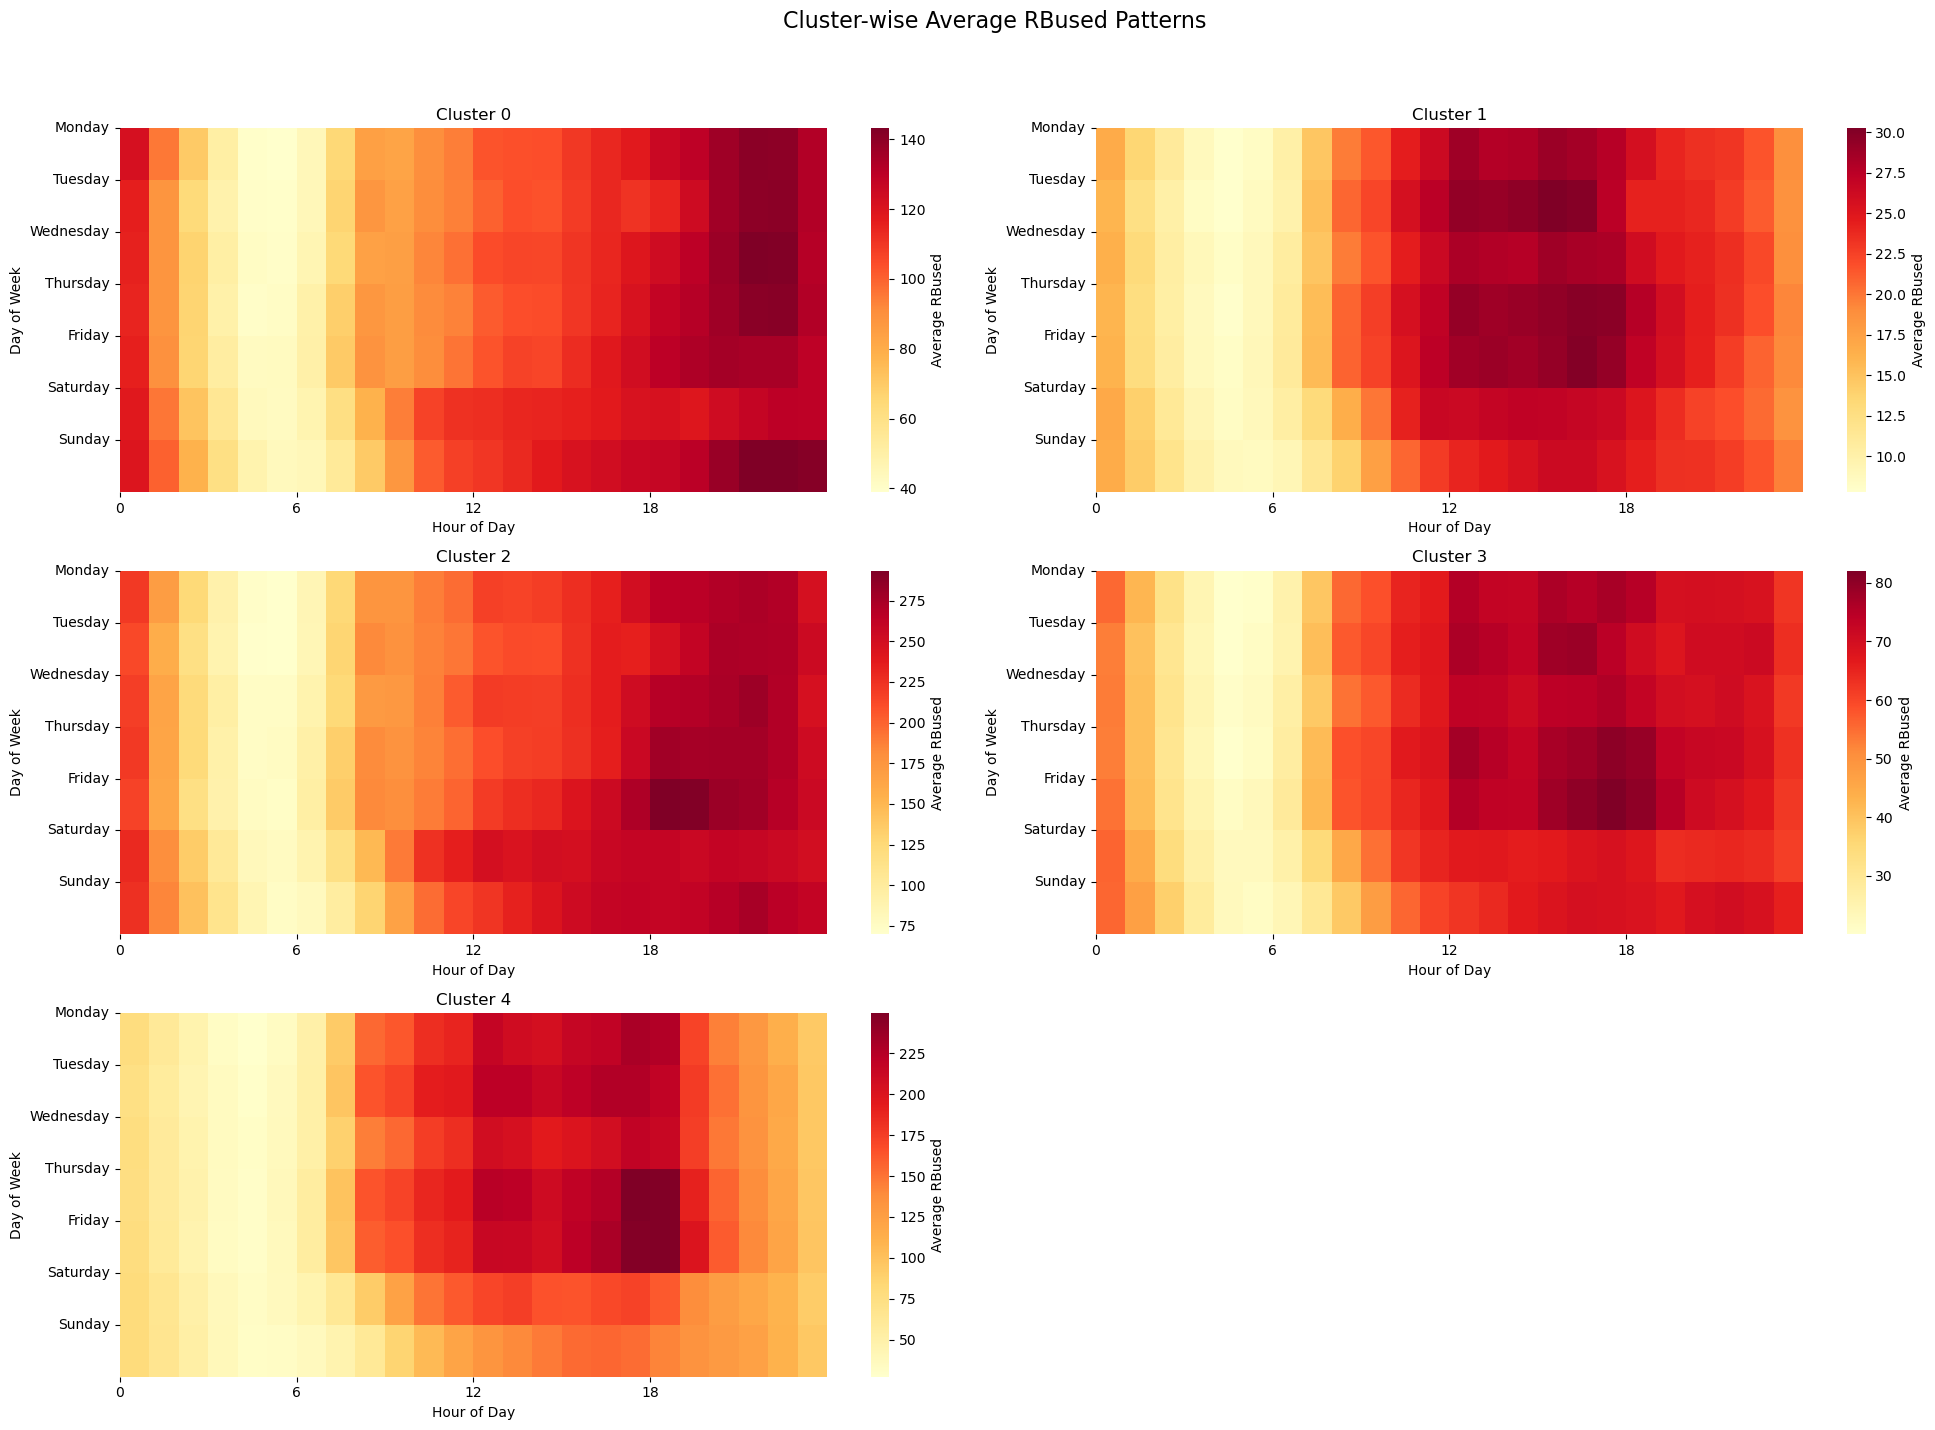

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# RBused 히트맵 생성
# 일주일간의 RBused 데이터 준비 (enbid_pci별 평균 사용)
weekly_rbused = df_hourly.groupby(['day_of_week', 'hour'])['RBused'].mean().unstack()

# 히트맵 그리기
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(weekly_rbused, cmap='YlOrRd', annot=False, cbar_kws={'label': 'Average RBused'})

# x축 레이블 설정 (시간)
plt.xticks(range(0, 24, 2), range(0, 24, 2))  # 2시간 간격으로 표시

# y축 레이블 설정 (요일)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.yticks(range(7), days)

plt.title('Average RBused by Day and Hour (Aggregated by enbid_pci)', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)

# 컬러바 레이블 설정
heatmap.collections[0].colorbar.set_label('Average RBused', fontsize=12)

plt.tight_layout()
plt.show()

# 클러스터별 히트맵 생성
fig, axes = plt.subplots(nrows=(n_clusters+1)//2, ncols=2, figsize=(20, 5*((n_clusters+1)//2)))
fig.suptitle("Cluster-wise Average RBused Patterns", fontsize=16)

for i in range(n_clusters):
    row = i // 2
    col = i % 2
    ax = axes[row, col] if n_clusters > 1 else axes
    
    cluster_data = df_hourly[df_hourly['enbid_pci'].isin(combined_features_scaled[combined_features_scaled['cluster'] == i].index)]
    cluster_weekly_rbused = cluster_data.groupby(['day_of_week', 'hour'])['RBused'].mean().unstack()
    
    sns.heatmap(cluster_weekly_rbused, cmap='YlOrRd', ax=ax, cbar=True, 
                cbar_kws={'label': 'Average RBused'})
    ax.set_title(f'Cluster {i}')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Day of Week')
    ax.set_xticks(range(0, 24, 6))
    ax.set_xticklabels(range(0, 24, 6))
    ax.set_yticks(range(7))
    ax.set_yticklabels(days, rotation=0)

# 사용하지 않는 서브플롯 제거
if n_clusters % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

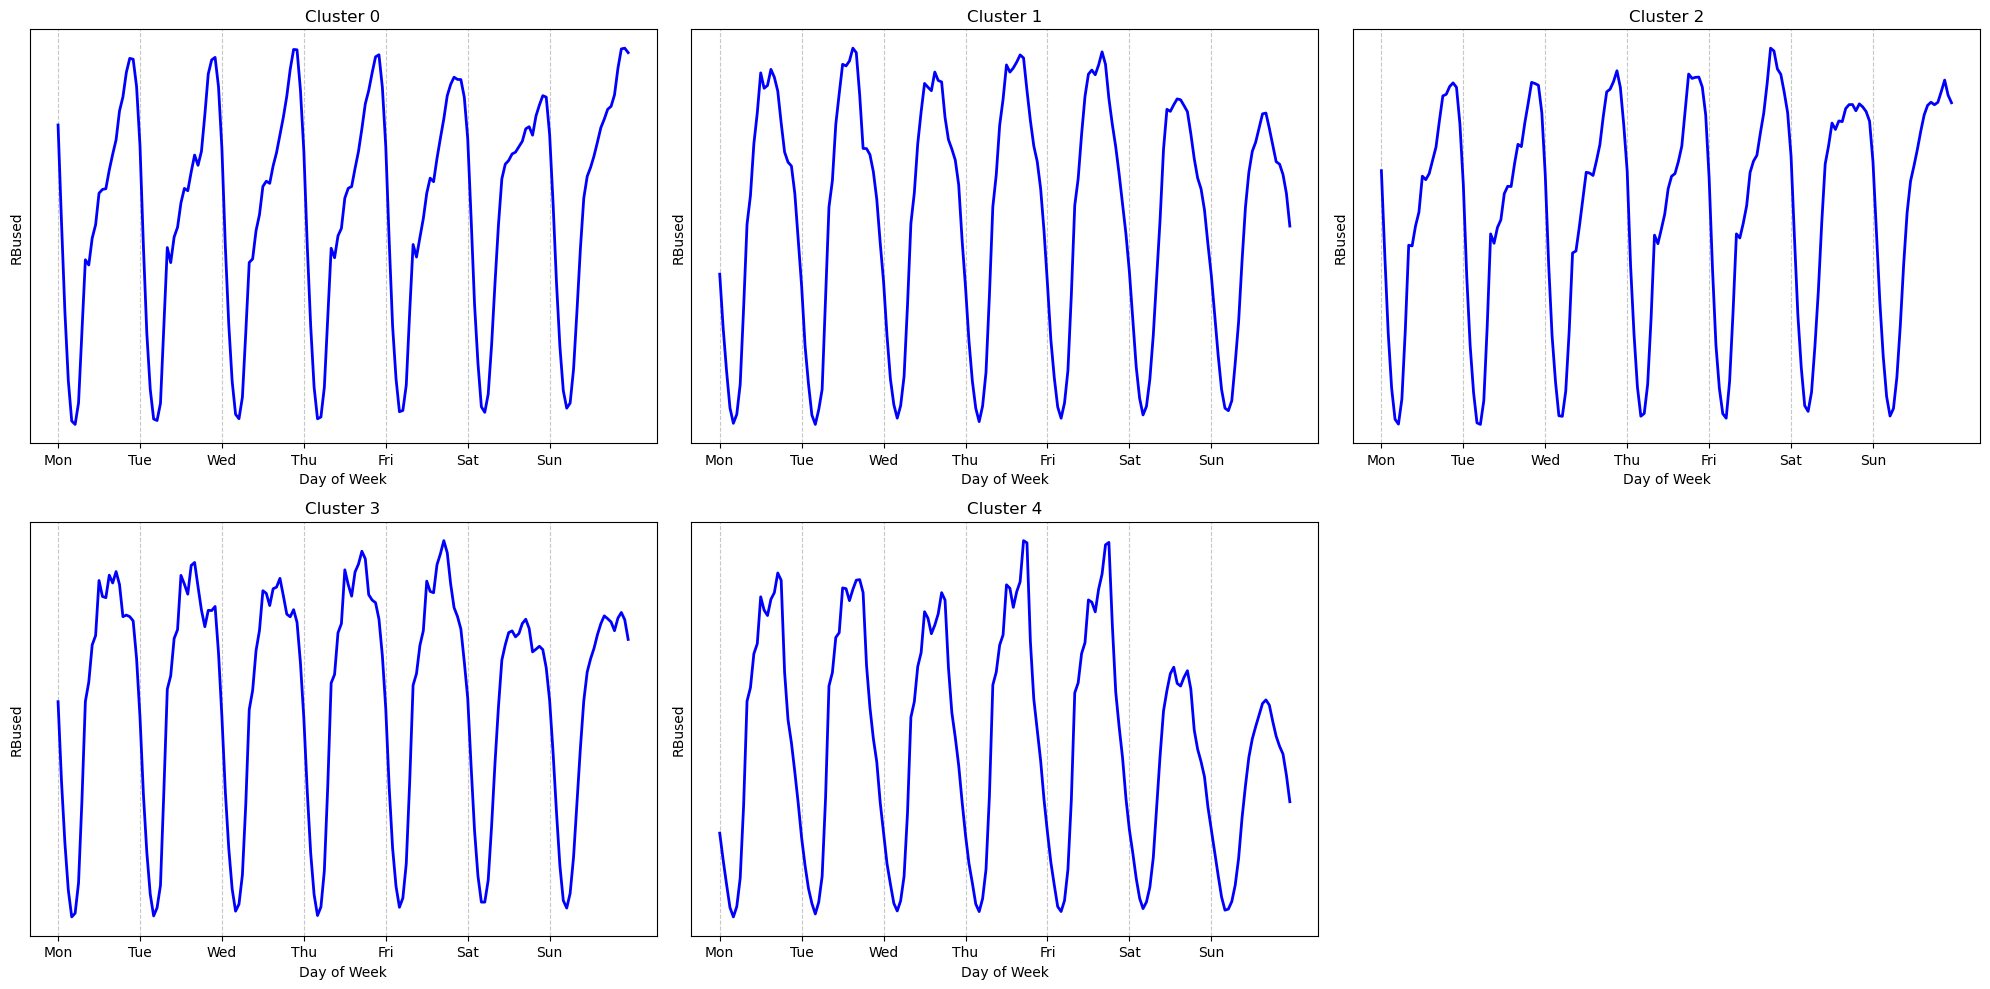

Number of data points per cluster:
cluster
0    284256
1    387072
2     78624
3    445536
4    106848
Name: count, dtype: int64


In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df_hourly and cluster_labels already exist
# First, ensure that cluster labels are correctly assigned to each enbid_pci
enbid_pci_cluster = pd.Series(cluster_labels, index=combined_features_scaled.index)
df_hourly['cluster'] = df_hourly['enbid_pci'].map(enbid_pci_cluster)

# Calculate average RBused for each hour of the week per cluster
weekly_pattern = df_hourly.groupby(['cluster', df_hourly['timestamp'].dt.dayofweek, df_hourly['timestamp'].dt.hour])['RBused'].mean().unstack(level=[1,2])

# Create the graph
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for i in range(n_clusters):
    ax = axes[i]
    if i in weekly_pattern.index:
        cluster_data = weekly_pattern.loc[i].values.flatten()
        
        # Handle missing values
        cluster_data = np.where(np.isnan(cluster_data), np.nanmean(cluster_data), cluster_data)
        
        ax.plot(range(len(cluster_data)), cluster_data, color='blue', linewidth=2)
        ax.set_title(f'Cluster {i}', fontsize=12)
        
        # Set x-axis
        ax.set_xticks(np.arange(0, 168, 24))
        ax.set_xticklabels(days)
        ax.set_xlabel('Day of Week')
        
        # Set y-axis
        ax.set_yticks([])
        ax.set_ylabel('RBused')
        
        ax.grid(True, linestyle='--', alpha=0.7)
    else:
        ax.set_title(f'Cluster {i} (No Data)', fontsize=12)

# Remove unused subplots
if n_clusters < 6:
    for j in range(n_clusters, 6):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("Number of data points per cluster:")
print(df_hourly['cluster'].value_counts().sort_index())

In [40]:
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm
import branca

# 클러스터링 결과를 enb_id에 매핑
enb_id_cluster = pd.DataFrame({'enbid_pci': combined_features.index, 'cluster': cluster_labels})

# 원본 데이터에 클러스터 정보 추가
df_with_clusters = df.merge(enb_id_cluster, on='enbid_pci', how='left')

# 지도 시각화
center_lat = df_with_clusters['ru_svc_lat_val'].mean()
center_lng = df_with_clusters['ru_svc_lng_val'].mean()
m = folium.Map(location=[center_lat, center_lng], zoom_start=12)

colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF',
          '#800000', '#008000', '#000080', '#808000', '#800080', '#008080',
          '#FFA500', '#FFC0CB', '#40E0D0', '#FF69B4', '#7B68EE', '#98FB98', '#DDA0DD']

# enbid_pci별로 그룹화하여 평균 위치와 클러스터 정보 계산
enbid_pci_group = df_with_clusters.groupby('enbid_pci').agg({
    'ru_svc_lat_val': 'mean',
    'ru_svc_lng_val': 'mean',
    'cluster': 'first',  # 각 enbid_pci에 대해 첫 번째 클러스터 값 사용
    'RBused': 'mean'
}).reset_index()

for idx, row in enbid_pci_group.iterrows():
    folium.CircleMarker(
        location=[row['ru_svc_lat_val'], row['ru_svc_lng_val']],
        radius=10,
        popup=f"enbid_pci: {row['enbid_pci']}, Cluster: {row['cluster']}, Avg RBused: {row['RBused']:.2f}",
        color=colors[int(row['cluster']) % len(colors)],
        fill=True,
        fillColor=colors[int(row['cluster']) % len(colors)],
        fillOpacity=0.7,
        stroke=True,
        weight=2
    ).add_to(m)

# 범례 추가
legend_html = '''
     <div style="position: fixed;
     top: 50px; right: 50px; width: 120px; height: 180px;
     border:2px solid grey; z-index:9999; font-size:14px;
     ">&nbsp; <b>Cluster Legend</b> <br>
     '''

for i in range(n_clusters):
    legend_html += f'<i class="fa fa-circle fa-1x" style="color:{colors[i]}"></i>&nbsp; Cluster {i}<br>'

legend_html += '</div>'

m.get_root().html.add_child(folium.Element(legend_html))

# 지도 저장
m.save("cluster_map_enbid_pci_with_legend.html")




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_enbid_pci_traffic(df, enbid_pci):
    # 해당 enbid_pci의 데이터만 필터링
    enbid_data = df[df['enbid_pci'] == enbid_pci]
    
    if enbid_data.empty:
        print(f"No data found for enbid_pci: {enbid_pci}")
        return
    
    # 일주일 동안의 평균 RBused 계산
    weekly_rbused = enbid_data.groupby(['day_of_week', 'hour'])['RBused'].mean().reset_index()
    
    # day_of_week와 hour를 이용해 연속적인 시간 인덱스 생성
    weekly_rbused['time_index'] = weekly_rbused['day_of_week'] * 24 + weekly_rbused['hour']
    weekly_rbused = weekly_rbused.sort_values('time_index')
    
    # 그래프 생성
    plt.figure(figsize=(20, 8))
    
    plt.plot(weekly_rbused['time_index'], weekly_rbused['RBused'], marker='o', linestyle='-', markersize=4)
    
    plt.title(f'Weekly RBused Traffic for enbid_pci: {enbid_pci}', fontsize=16)
    plt.xlabel('Day and Hour', fontsize=12)
    plt.ylabel('Average RBused', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # X축 레이블 설정
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    xticks = range(0, 168, 24)
    plt.xticks(xticks, days)
    
    # 각 날짜 변경 시점에 수직선 추가
    for day in range(1, 7):
        plt.axvline(x=day*24, color='r', linestyle='--', alpha=0.5)
    
    # Y축 범위 설정 (최소값의 90%부터 최대값의 110%까지)
    y_min = weekly_rbused['RBused'].min() * 0.9
    y_max = weekly_rbused['RBused'].max() * 1.1
    plt.ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.show()
    
    # 기본 통계 출력
    print(f"\nBasic Statistics for enbid_pci {enbid_pci}:")
    print(enbid_data['RBused'].describe())

# 사용 예시:
visualize_enbid_pci_traffic(df, '34804_252')